<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c670_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [58]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
c670_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c670_data.xlsx',index_col=0)
print(c670_df.shape)
c670_df.head(3)

(168, 171)


,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

# 缺失欄位

In [59]:
miss_col = c670_df.columns[(c670_df.isnull().sum() > 0).values].tolist()
print(len(miss_col))
miss_col

84


['Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Hydrogen_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Methane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Ethane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_Propane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Butane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Pentane_Fraction',
 'Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Distillate_n-Hexane_Fraction',
 'Toluene Column C670 S

# 有提供欄位

In [60]:
have_col = c670_df.columns[(c670_df.isnull().sum() == 0).values].tolist()
print(len(have_col))
have_col

87


['Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%',
 'Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detai

In [62]:
x_col = c['combined'] + c['upper_bf']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']

In [63]:
c670_df[x_col].head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [64]:
c670_df[op_col].head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
2020-09-02,0.871,0.876,359.973294,NaN,NaN,182.338802,228.030248
2020-09-03,0.871,0.876,360.169653,NaN,NaN,182.173319,227.882516
2020-09-04,0.871,0.876,364.094576,NaN,NaN,181.966652,227.734090
2020-09-05,0.871,0.876,366.551051,NaN,NaN,182.871303,228.661995
2020-09-06,0.871,0.876,356.315479,NaN,NaN,182.011838,227.636594


In [65]:
y_col = c670_df[op_col].dropna(axis=1).columns.tolist()
y_col

['Density_Distillate Production Rate and Composition',
 'Density_Bottoms Production Rate and Composition',
 'Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr',
 'Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC',
 'Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC']

In [66]:
c670_df[y_col].head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
2020-09-02,0.871,0.876,359.973294,182.338802,228.030248
2020-09-03,0.871,0.876,360.169653,182.173319,227.882516
2020-09-04,0.871,0.876,364.094576,181.966652,227.734090
2020-09-05,0.871,0.876,366.551051,182.871303,228.661995
2020-09-06,0.871,0.876,356.315479,182.011838,227.636594


# 1. 實驗直接訓練 (不使用預訓練模型)

  7%|▋         | 21/300 [00:00<00:02, 97.74it/s]

epoch:0 train_loss:0.0468 valid_loss:0.0269


 21%|██        | 62/300 [00:00<00:02, 100.11it/s]

epoch:50 train_loss:0.0015 valid_loss:0.0066


 38%|███▊      | 115/300 [00:01<00:01, 95.12it/s] 

epoch:100 train_loss:0.0012 valid_loss:0.0066


 55%|█████▍    | 164/300 [00:01<00:01, 90.66it/s]

epoch:150 train_loss:0.0009 valid_loss:0.0067


 72%|███████▏  | 215/300 [00:02<00:00, 92.13it/s]

epoch:200 train_loss:0.0008 valid_loss:0.0070


 86%|████████▋ | 259/300 [00:02<00:00, 75.41it/s]

epoch:250 train_loss:0.0007 valid_loss:0.0073


100%|██████████| 300/300 [00:03<00:00, 87.58it/s]


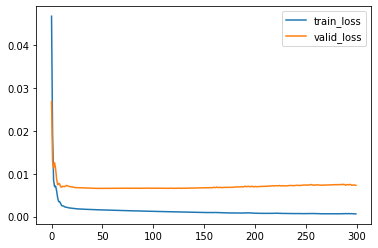

In [67]:
from autorch.utils import PartBulider
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.train()

In [68]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,5.69196e-06,0.239884
Density_Bottoms Production Rate and Composition,0.0552537,1.5495e-06,0.0506826
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.830837,24.3672,0.98152
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,0.809349,0.394479
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.854178,0.800869,0.320263
AVG,0.348054,5.19549,0.397366


# 2.使用預訓練模型

2.1 用模擬數據先預訓練一個模型

  0%|          | 1/300 [00:00<03:22,  1.48it/s]

epoch:0 train_loss:0.0029 valid_loss:0.0002


 17%|█▋        | 51/300 [00:39<03:19,  1.25it/s]

epoch:50 train_loss:0.0000 valid_loss:0.0000


 34%|███▎      | 101/300 [01:20<02:44,  1.21it/s]

epoch:100 train_loss:0.0000 valid_loss:0.0000


 50%|█████     | 151/300 [02:04<02:14,  1.11it/s]

epoch:150 train_loss:0.0000 valid_loss:0.0000


 67%|██████▋   | 201/300 [02:51<01:37,  1.02it/s]

epoch:200 train_loss:0.0000 valid_loss:0.0000


 84%|████████▎ | 251/300 [03:43<00:52,  1.07s/it]

epoch:250 train_loss:0.0000 valid_loss:0.0000


100%|██████████| 300/300 [04:38<00:00,  1.08it/s]


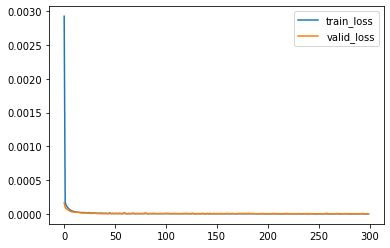

In [69]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0)
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.train()

In [70]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.999964,2.99081e-14,1.58738e-05
Density_Bottoms Production Rate and Composition,0.999988,2.18274e-12,0.000123178
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.999906,0.0582473,0.0657458
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.999935,3.77937e-06,0.000787404
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.999974,7.12319e-05,0.002627
AVG,0.999953,0.0116645,0.0138599


2.2 把預訓練好的模型抽出來

In [71]:
import copy
from copy import deepcopy
pretrain_net = deepcopy(c670.net)
pretrain_net

Sequential(
  (0): Linear(in_features=82, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=5, bias=True)
  (5): Sigmoid()
)

2.3 在預訓練模型上丟進真實資料繼續訓練

  6%|▋         | 19/300 [00:00<00:03, 85.33it/s]

epoch:0 train_loss:0.0022 valid_loss:0.0022


 23%|██▎       | 69/300 [00:00<00:02, 93.75it/s]

epoch:50 train_loss:0.0006 valid_loss:0.0011


 40%|███▉      | 119/300 [00:01<00:01, 92.24it/s]

epoch:100 train_loss:0.0006 valid_loss:0.0012


 56%|█████▋    | 169/300 [00:01<00:01, 91.66it/s]

epoch:150 train_loss:0.0006 valid_loss:0.0016


 73%|███████▎  | 219/300 [00:02<00:00, 95.05it/s]

epoch:200 train_loss:0.0005 valid_loss:0.0016


 90%|████████▉ | 269/300 [00:02<00:00, 91.82it/s]

epoch:250 train_loss:0.0004 valid_loss:0.0016


100%|██████████| 300/300 [00:03<00:00, 92.36it/s]


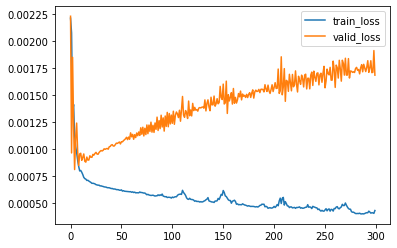

In [78]:
from torch.optim import Adam
c670_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c670_data.xlsx',index_col=0)
c670 = PartBulider(c670_df,x_col,y_col,limit_y_range=True)
c670.net = pretrain_net
c670.optimizer = Adam(c670.net.parameters(),lr=0.001)
c670.train()

In [79]:
c670.test(e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,1.37192e-09,0.00351018
Density_Bottoms Production Rate and Composition,0.799959,8.85971e-08,0.0183753
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.939743,11.1288,0.680629
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.382657,0.274717,0.252419
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.576124,0.343836,0.224175
AVG,0.539697,2.34947,0.235822


In [80]:
c670.shrink()

In [81]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_op_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670_op_real_data.pkl']